## Festival 

In [7]:
import numpy as np
import pandas as pd

# 한글 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib
plt.style.use('ggplot')  # 차트스타일은 원하는 걸로, 난 ggplot
%matplotlib inline

# 나눔 고딕으로 설정을 바꾼다
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨질 경우 대비

import seaborn as sns

# Suppress Deprecation and Incorrect Usage Warnings 
import warnings
warnings.filterwarnings('ignore')

#### 분석 주제

1. 팀별 점수 분포 : 종합점수 및 각 항목별, 표준편차
2. 심사위원 성향 : 종합점수 표준편차 
3. 배점 항목별 관계 분석 : scatter matrix, 상관계수행렬, 회귀분석(종합점수에 가장 큰 영향은?)
4. 클러스터링맵 : 팀X심사위원 관계 시각화

In [110]:
# 데이터 읽기
df = pd.read_csv('data\\festival.txt', sep='\t') 

# 항목별 순위 부여(동점 다수 있음)
df_rank = df.iloc[:,2:5].rank(axis=1, ascending=False)
df_rank.columns = ['적합성논리성순위','창의성독창성순위','실현가능성순위']
df = pd.concat([df, df_rank], axis=1)

# 점수별 표준편차
df['std'] = df.iloc[:,2:5].std(axis=1)   # pandas의 std함수를 쓰면 간편하다. 
df.head(2)

,팀,심사위원,적합성논리성,창의성독창성,실현가능성,종합점수,적합성논리성순위,창의성독창성순위,실현가능성순위,std
0,BM,WEST,70,50,80,200,2.0,3.0,1.0,15.275252
1,JD,WEST,80,70,60,210,1.0,2.0,3.0,10.000000


---
팀별 점수 분포 : 종합점수 및 각 항목별, 표준편차

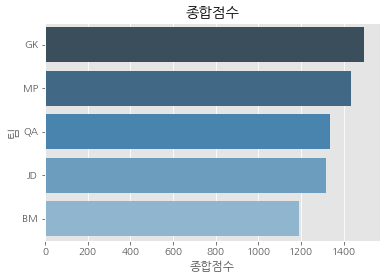

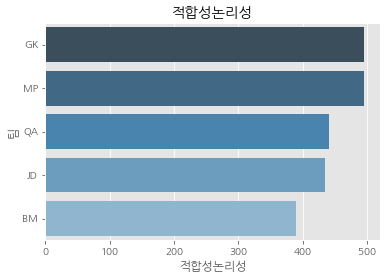

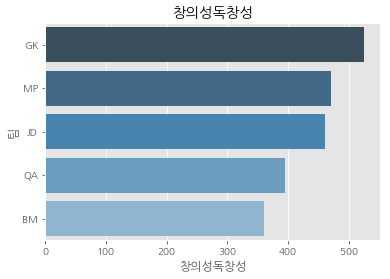

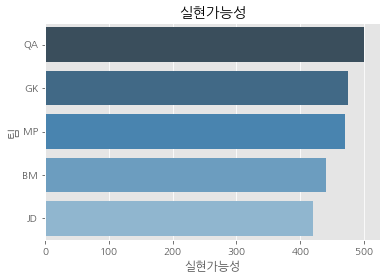

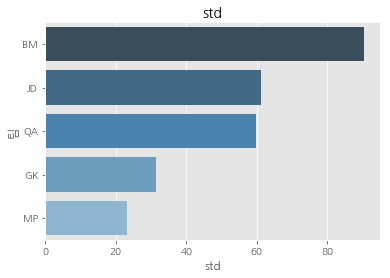

In [63]:
def team_plot(score_type):
    res = pd.DataFrame(df.groupby(['팀'], as_index=False)[score_type].sum())
    g = sns.barplot(x=score_type, y='팀', 
                    data=res.sort_values(by=score_type, ascending=False),
                    palette="Blues_d")
    plt.title(score_type)
    plt.show()
    
team_plot('종합점수')
team_plot('적합성논리성')
team_plot('창의성독창성')
team_plot('실현가능성')
team_plot('std')

---
심사위원 : 팀별 종합점수 배점 표준편차(가장 변별력이 큰)

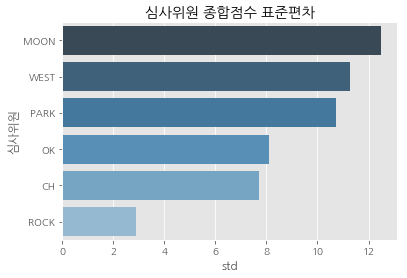

In [105]:
res = pd.DataFrame(df.groupby(['심사위원'], as_index=False)['std'].mean())
g = sns.barplot(x='std', y='심사위원', 
                data=res.sort_values('std', ascending=False),
                palette="Blues_d")
plt.title('심사위원 종합점수 표준편차')
plt.show()

---
항목별 관계 검토 : 총점+3개 항목 scatter matrix, 상관계수행렬, 회귀분석(종합점수에 가장 큰 영향은?)

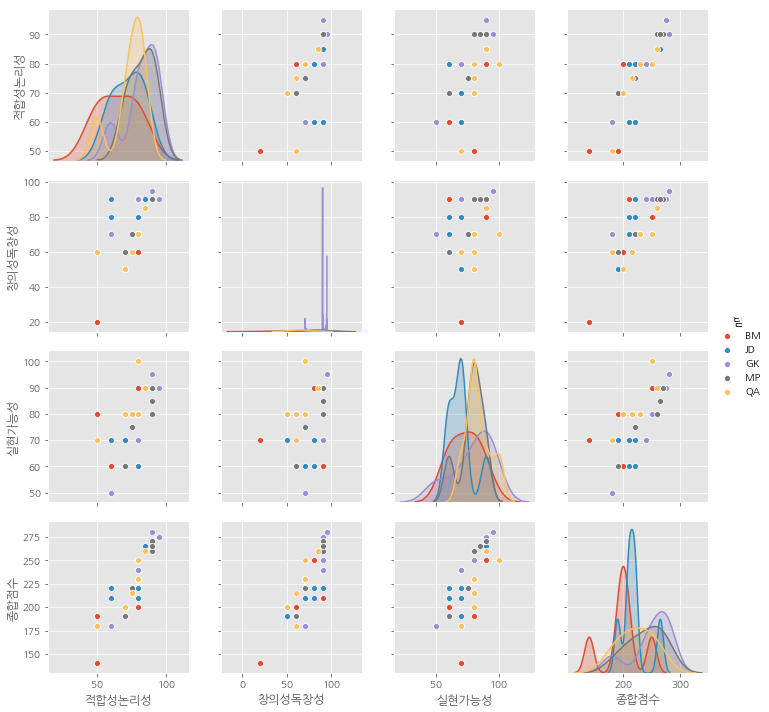

In [70]:
g = sns.pairplot(df.iloc[:,[0,2,3,4,5]], hue='팀')

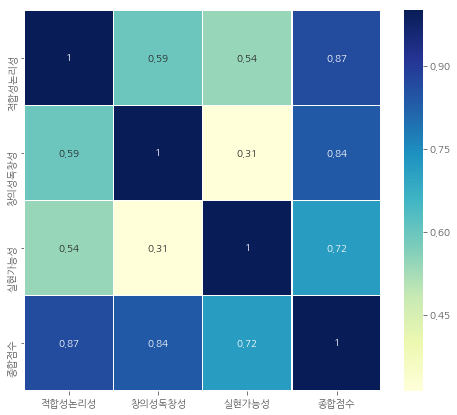

In [79]:
# 점수간의 상관계수 시각화
corr = df.iloc[:, 2:6].corr()
plt.figure(figsize=(8,7))
g = sns.heatmap(corr, annot=True, linewidths=0.5, cmap="YlGnBu")

---
다중 선형 회귀식 적합 후 분석분석표로 회귀계수값 크기 해석 : F값이 클수록 강한 상관관계  
https://www.statsmodels.org/stable/anova.html?highlight=anova_lm  
https://www.scipy-lectures.org/packages/statistics/auto_examples/plot_regression_3d.html

In [89]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols("종합점수 ~ 적합성논리성 + 창의성독창성 + 실현가능성", df).fit()
# print(model.summary())

anova_results = anova_lm(model)
print(anova_results)

            df        sum_sq       mean_sq             F  PR(>F)
적합성논리성     1.0  2.621956e+04  2.621956e+04  1.060194e+30     0.0
창의성독창성     1.0  5.655675e+03  5.655675e+03  2.286885e+29     0.0
실현가능성      1.0  3.161435e+03  3.161435e+03  1.278333e+29     0.0
Residual  26.0  6.430037e-25  2.473091e-26           NaN     NaN


[해석] 상관계수 행렬의 결과와 동일한 결과  
F값으로 해석해보면, 종합점수에 미치는 영향력은 적합성논리성 > 창의성독창성 > 실현가능성 순

---
클러스터링맵(팀X심사위원)

In [111]:
tot_score = pd.pivot_table(df, 
                           values  ='종합점수',
                           index   ='심사위원',
                           columns ='팀',
                           aggfunc =np.sum)
# tot_score

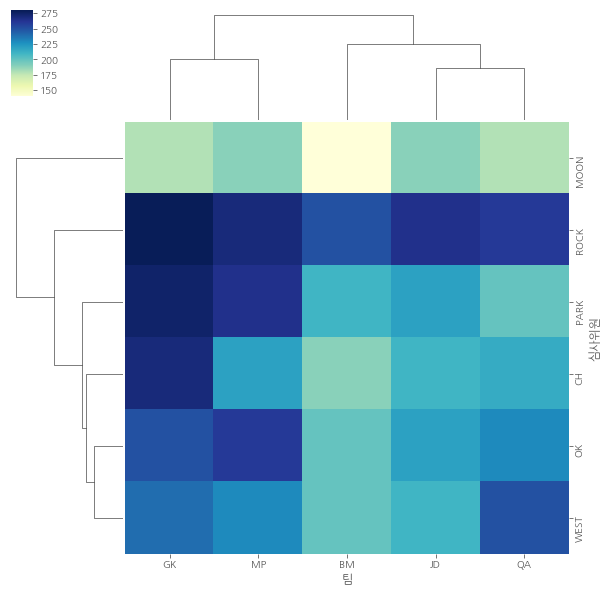

In [101]:
g = sns.clustermap(tot_score, cmap="YlGnBu")